1. Setup & Load

In [1]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

PROC = Path("data/processed")
FIG  = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL  = Path("reports/tables");  TBL.mkdir(parents=True, exist_ok=True)

merged = (pd.read_csv(PROC/"merged_gold_btc_monthly_2020_2025.csv", parse_dates=["Date"])
            .set_index("Date").sort_index())
ret_path = PROC/"monthly_returns_gold_btc_2020_2025.csv"

if ret_path.exists():
    ret = (pd.read_csv(ret_path, parse_dates=["Date"]).set_index("Date").sort_index())
else:
    ret = (merged.assign(
            Gold_ret = np.log(merged["Gold_USD"]).diff(),
            BTC_ret  = np.log(merged["BTC_USD"]).diff())
          .replace([np.inf, -np.inf], np.nan)
          .dropna(subset=["Gold_ret","BTC_ret"]))
    ret.to_csv(ret_path, index_label="Date")


2. Summary Table (Levels, Returns, Full + Spearman Correlation)

In [2]:
# Levels summary
level_summary = merged.describe().round(3)
level_summary.to_csv(TBL/"level_summary.csv", index=True)

# Returns summary
returns_summary = ret[["Gold_ret","BTC_ret"]].describe().round(4)
returns_summary.to_csv(TBL/"returns_summary.csv", index=True)

# Pearson full-period + 95% CI (Fisher z)
n = len(ret)
r, p = stats.pearsonr(ret["Gold_ret"], ret["BTC_ret"])
z = np.arctanh(np.clip(r, -0.999999, 0.999999))
zcrit = stats.norm.ppf(1-0.05/2); se = 1/np.sqrt(n-3)
ci_lo, ci_hi = np.tanh([z - zcrit*se, z + zcrit*se])
pd.DataFrame([{"n_months":n,"pearson_r":r,"p_value":p,"ci95_lo":ci_lo,"ci95_hi":ci_hi}])\
  .round(6).to_csv(TBL/"correlation_fullperiod.csv", index=False)

# Spearman (robustness)
rho, p_s = stats.spearmanr(ret["Gold_ret"], ret["BTC_ret"], nan_policy="omit")
pd.DataFrame([{"n_months":n,"spearman_rho":rho,"p_value":p_s}]).round(6)\
  .to_csv(TBL/"correlation_spearman.csv", index=False)


3. Figure: Level (Log), Returns, Scatter + Regression, Histogram

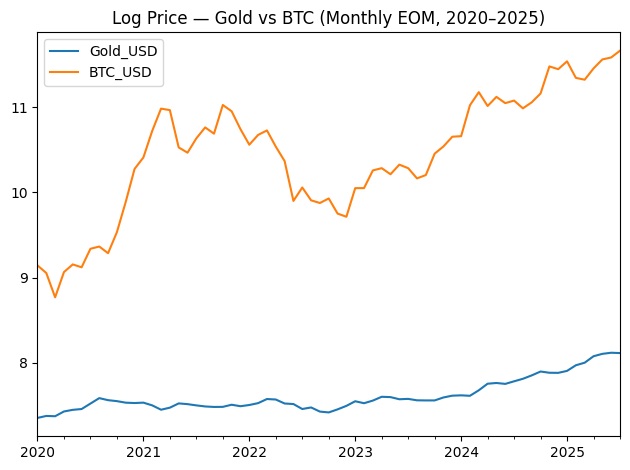

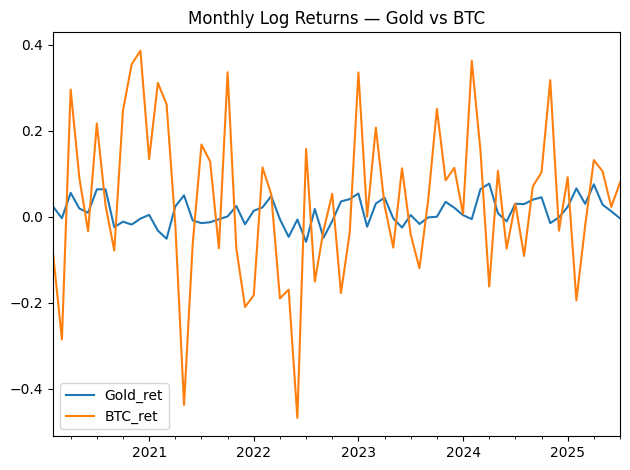

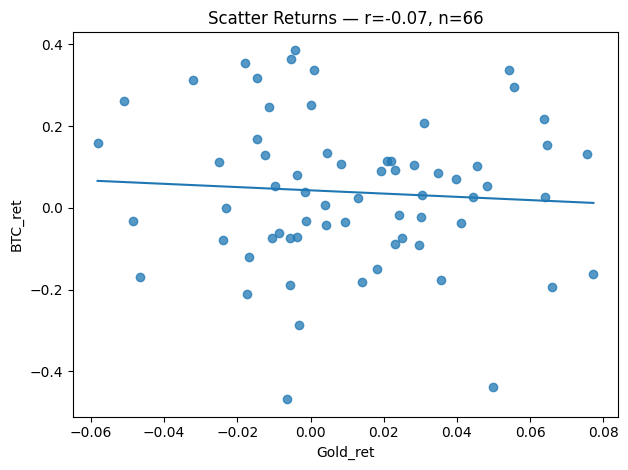

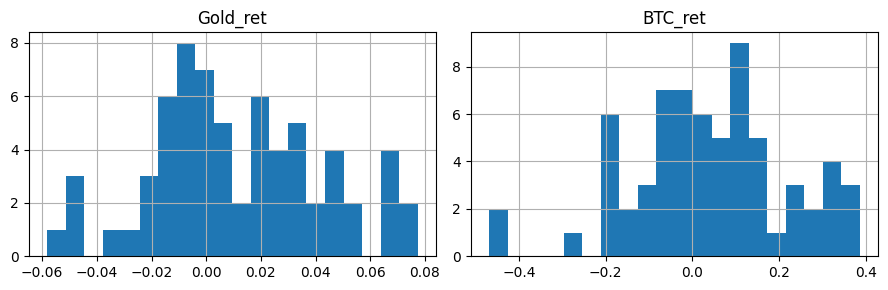

In [3]:
# Level log-price
ax = np.log(merged[["Gold_USD","BTC_USD"]]).plot(title="Log Price — Gold vs BTC (Monthly EOM, 2020–2025)")
ax.set_xlabel(""); plt.tight_layout(); plt.savefig(FIG/"level_logprice_gold_btc.png", dpi=150); plt.show()

# Returns line
ax = ret[["Gold_ret","BTC_ret"]].plot(title="Monthly Log Returns — Gold vs BTC")
ax.set_xlabel(""); plt.tight_layout(); plt.savefig(FIG/"returns_line_gold_btc.png", dpi=150); plt.show()

# Scatter + best-fit line
x, y = ret["Gold_ret"].to_numpy(), ret["BTC_ret"].to_numpy()
slope, intercept, r_val, p_val, _ = stats.linregress(x, y)
xline = np.linspace(x.min(), x.max(), 100)
plt.figure(); plt.scatter(x, y, alpha=0.75); plt.plot(xline, intercept + slope*xline)
plt.title(f"Scatter Returns — r={r:.2f}, n={n}"); plt.xlabel("Gold_ret"); plt.ylabel("BTC_ret")
plt.tight_layout(); plt.savefig(FIG/"scatter_returns_gold_btc.png", dpi=150); plt.show()

# Histogram returns
ret[["Gold_ret","BTC_ret"]].hist(bins=20, layout=(1,2), figsize=(9,3)); plt.tight_layout()
plt.savefig(FIG/"hist_returns_gold_btc.png", dpi=150); plt.show()


4. Rolling Correlations (6M/12M) + Summary

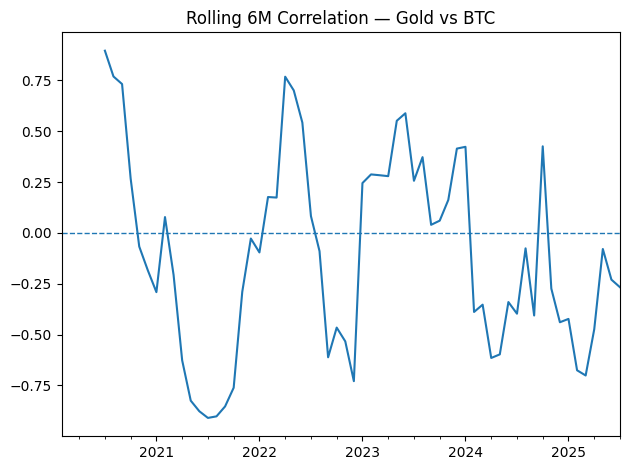

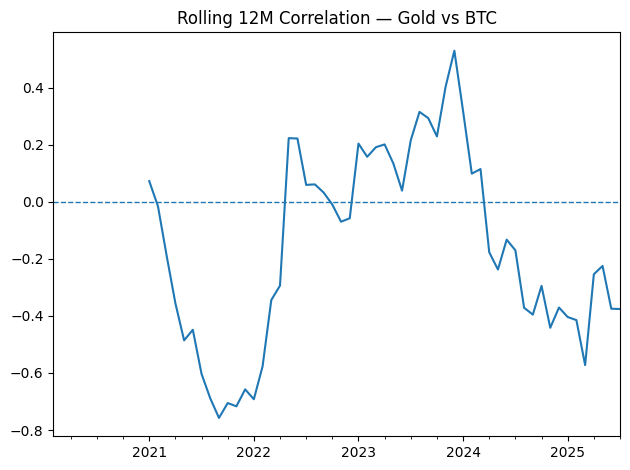

Saved tables  → ['04_merge_qc_summary.csv', 'correlation_by_subperiod.csv', 'correlation_fullperiod.csv', 'correlation_rolling_summary.csv', 'correlation_spearman.csv', 'dataset_summary.csv', 'data_dictionary.csv', 'level_summary.csv', 'manifest_processed.csv', 'qc_freeze_summary.csv', 'qc_missing_btc.csv', 'qc_missing_gold.csv', 'qc_missing_merged.csv', 'qc_missing_returns.csv', 'returns_summary.csv', 'robustness_correlation.csv', 'robustness_crosscorr_lags.csv', 'robustness_jackknife_all.csv', 'robustness_outliers_influence.csv', 'robustness_rolling_windows.csv']
Saved figures → ['03_level_dualaxis.png', '03_level_rebased100.png', '04_levels_premerge_dualaxis.png', '04_postmerge_coverage_heatmap.png', '04_premerge_coverage_heatmap.png', '04_premerge_yearly_completeness.png', '04_returns_hist_kde.png', '05_returns_overlay.png', '05_scatter_hexbin.png', '05_scatter_returns.png', '06_coverage_heatmap.png', 'bootstrap_corr_hist.png', 'crosscorr_lags.png', 'hist_returns_gold_btc.png', 'ja

In [4]:
roll6  = ret["Gold_ret"].rolling(6).corr(ret["BTC_ret"])
roll12 = ret["Gold_ret"].rolling(12).corr(ret["BTC_ret"])

ax = roll6.plot(title="Rolling 6M Correlation — Gold vs BTC")
ax.axhline(0, ls="--", lw=1); ax.set_xlabel("")
plt.tight_layout(); plt.savefig(FIG/"rolling_corr_6M.png", dpi=150); plt.show()

ax = roll12.plot(title="Rolling 12M Correlation — Gold vs BTC")
ax.axhline(0, ls="--", lw=1); ax.set_xlabel("")
plt.tight_layout(); plt.savefig(FIG/"rolling_corr_12M.png", dpi=150); plt.show()

def frac_neg(s): s = s.dropna(); return 0.0 if len(s)==0 else (s.lt(0).mean())
pd.DataFrame({
    "roll6_mean":[roll6.mean()], "roll6_min":[roll6.min()], "roll6_max":[roll6.max()], "roll6_frac_neg":[frac_neg(roll6)],
    "roll12_mean":[roll12.mean()], "roll12_min":[roll12.min()], "roll12_max":[roll12.max()], "roll12_frac_neg":[frac_neg(roll12)],
}).round(6).to_csv(TBL/"correlation_rolling_summary.csv", index=False)

print("Saved tables  →", [p.name for p in TBL.glob("*.csv")])
print("Saved figures →", [p.name for p in FIG.glob("*.png")])
